In [3]:
# Imports
import py4DSTEM
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter1d
from matplotlib.path import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Enable interactive plotting
%matplotlib widget
# Alternative: %matplotlib notebook

In [4]:
# Configuration
filename = r"G:\Analytik\Personal\Vivek\PC_Titan_EMPA\PED\20250411_PED_3051NI_4nm_01\1700_file.h5"
output_dir = r"G:\Analytik\Personal\Vivek\PC_Titan_EMPA\PED\20250411_PED_3051NI_4nm_01"
scan_step_nm = 4
crop_bottom_nm = 250

## Step 1: Load and Process Raw Data
This cell loads the HDF5 file and calculates the density map from diffraction patterns. This takes time, so run it once and reuse the results.

In [5]:
# Load the .h5 file using py4DSTEM
s = py4DSTEM.io.read(filename)

print(f"Data dimensions: {s.data.shape}")
print(f"Data type: {s.data.dtype}")

data = s.data

Data dimensions: (300, 360, 144, 144)
Data type: uint8


In [6]:
# Calculate density metric from diffraction patterns
# This takes several minutes - run once and save the result

# Create radial coordinate system
y, x = np.indices(data.shape[2:])
center = np.array([(y.max() - y.min()) / 2.0, (x.max() - x.min()) / 2.0])
r = np.sqrt((y - center[0])**2 + (x - center[1])**2)
r = r.astype(int)

# Initialize density map
density_map = np.zeros(data.shape[:2])

# Calculate a density metric for each position in the map
print("Processing diffraction patterns...")
for i in range(data.shape[0]):
    if i % 10 == 0:
        print(f"Processing row {i}/{data.shape[0]}")
    for j in range(data.shape[1]):
        # Get diffraction pattern at this position
        dp = data[i, j]
        
        # Calculate radial profile
        r_profile = np.bincount(r.ravel(), dp.ravel())
        
        # Normalize by number of pixels
        r_norm = np.bincount(r.ravel())
        r_profile = r_profile / r_norm
        
        # Calculate first moment (center of mass) of the radial profile
        r_indices = np.arange(len(r_profile))
        first_moment = np.sum(r_profile * r_indices) / np.sum(r_profile)
        
        # Store in density map
        density_map[i, j] = first_moment

print("Processing complete!")
print(f"Density map shape: {density_map.shape}")

Processing diffraction patterns...
Processing row 0/300
Processing row 10/300
Processing row 10/300
Processing row 20/300
Processing row 20/300
Processing row 30/300
Processing row 30/300
Processing row 40/300
Processing row 40/300
Processing row 50/300
Processing row 50/300
Processing row 60/300
Processing row 60/300
Processing row 70/300
Processing row 70/300
Processing row 80/300
Processing row 80/300
Processing row 90/300
Processing row 90/300
Processing row 100/300
Processing row 100/300
Processing row 110/300
Processing row 110/300
Processing row 120/300
Processing row 120/300
Processing row 130/300
Processing row 130/300
Processing row 140/300
Processing row 140/300
Processing row 150/300
Processing row 150/300
Processing row 160/300
Processing row 160/300
Processing row 170/300
Processing row 170/300
Processing row 180/300
Processing row 180/300
Processing row 190/300
Processing row 190/300
Processing row 200/300
Processing row 200/300
Processing row 210/300
Processing row 210/

## Step 2: Interactive Plot for Polygon Definition
Use this to hover and find coordinates for defining the Pt region polygon

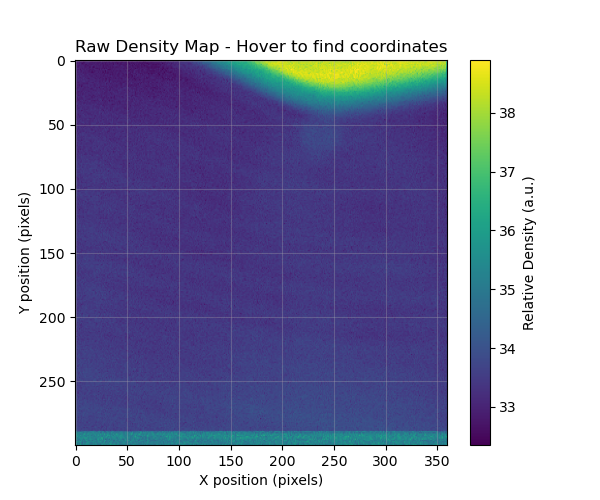

Hover over the image to see coordinates at the bottom of the plot.
Use these to define your polygon vertices.


In [7]:
# Plot raw density map with interactive coordinates
# Hover over the image to see x, y coordinates and density values

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(density_map, cmap='viridis', aspect='auto')
ax.set_title('Raw Density Map - Hover to find coordinates')
ax.set_xlabel('X position (pixels)')
ax.set_ylabel('Y position (pixels)')
plt.colorbar(im, ax=ax, label='Relative Density (a.u.)')
ax.grid(True, alpha=0.3)
plt.show()

print("Hover over the image to see coordinates at the bottom of the plot.")
print("Use these to define your polygon vertices.")

## Step 3: Define Polygon and Process
Update the polygon coordinates based on the interactive plot above

In [8]:
# Define the Pt region polygon
# Update these coordinates based on the interactive plot above
pt_polygon = [(120, 0), (360, 0), (360, 29), (300, 39), (230, 42), (210, 39),
              (200, 35), (190, 32), (180, 29), (170, 24), (150, 16), (140, 10), (120, 0)]

print(f"Polygon defined with {len(pt_polygon)} vertices")

Polygon defined with 13 vertices


In [9]:
# Crop bottom region
pixels_to_crop = int(crop_bottom_nm / scan_step_nm)
print(f"Cropping bottom {crop_bottom_nm} nm ({pixels_to_crop} pixels)")

density_cropped = density_map[:-pixels_to_crop, :] if pixels_to_crop > 0 else density_map.copy()
height, width = density_cropped.shape
print(f"Cropped shape: {density_cropped.shape}")

Cropping bottom 250 nm (62 pixels)
Cropped shape: (238, 360)


In [10]:
# Create polygon mask
y_grid, x_grid = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
points = np.vstack((x_grid.ravel(), y_grid.ravel())).T

polygon_path = Path(pt_polygon)
mask = polygon_path.contains_points(points).reshape(height, width)

# Create masked version
density_masked = density_cropped.copy()
density_masked[mask] = np.nan
density_masked[0:2, :] = np.nan  # Remove top 2 rows

print(f"Masked {np.sum(mask)} pixels out of {height * width} total")

Masked 7474 pixels out of 85680 total


In [11]:
# Calculate color scale limits
roi_data = density_masked[~np.isnan(density_masked)]
vmin_roi = np.min(roi_data)
vmax_roi = 35.0  # Saturate to highlight differences

print(f"ROI colorbar range: {vmin_roi:.3f} to {vmax_roi:.3f} (saturated)")
print(f"Actual ROI max: {np.max(roi_data):.3f}")

print("\n=== Density Map Statistics (ROI only) ===")
print(f"Mean density: {np.mean(roi_data):.3f}")
print(f"Std deviation: {np.std(roi_data):.3f}")
print(f"Min density: {np.min(roi_data):.3f}")
print(f"Max density: {np.max(roi_data):.3f}")
print(f"Density range: {np.max(roi_data) - np.min(roi_data):.3f}")

ROI colorbar range: 32.352 to 35.000 (saturated)
Actual ROI max: 34.248

=== Density Map Statistics (ROI only) ===
Mean density: 33.367
Std deviation: 0.192
Min density: 32.352
Max density: 34.248
Density range: 1.896


## Step 4: Visualize Results

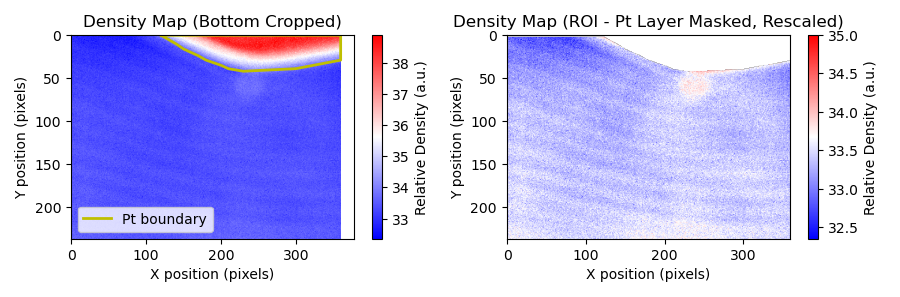

In [12]:
# Create custom colormap
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
cm = LinearSegmentedColormap.from_list('density_cmap', colors, N=256)

# Plot comparison
# Calculate aspect ratio for each subplot
aspect_ratio = density_cropped.shape[0] / density_cropped.shape[1]  # height/width
subplot_width = 4.5
subplot_height = subplot_width * aspect_ratio

fig, axes = plt.subplots(1, 2, figsize=(subplot_width * 2, subplot_height))

# Plot 1: Cropped with polygon overlay
im1 = axes[0].imshow(density_cropped, cmap=cm, aspect='auto')
axes[0].set_title('Density Map (Bottom Cropped)')
axes[0].set_xlabel('X position (pixels)')
axes[0].set_ylabel('Y position (pixels)')

# Draw polygon boundary
polygon_array = np.array(pt_polygon)
axes[0].plot(polygon_array[:, 0], polygon_array[:, 1], 'y-', linewidth=2, label='Pt boundary')
axes[0].legend()
plt.colorbar(im1, ax=axes[0], label='Relative Density (a.u.)')

# Plot 2: Masked and rescaled
im2 = axes[1].imshow(density_masked, cmap=cm, aspect='auto', vmin=vmin_roi, vmax=vmax_roi)
axes[1].set_title('Density Map (ROI - Pt Layer Masked, Rescaled)')
axes[1].set_xlabel('X position (pixels)')
axes[1].set_ylabel('Y position (pixels)')
plt.colorbar(im2, ax=axes[1], label='Relative Density (a.u.)')

plt.tight_layout()
plt.savefig(f'{output_dir}\\density_map_4nm_processed.png', dpi=300)
plt.show()

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


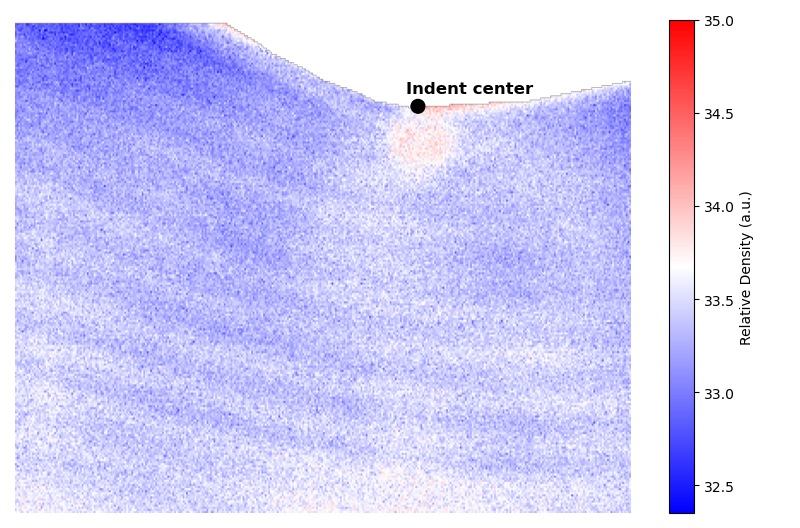

In [13]:
# Final processed result only
# Calculate aspect ratio to prevent squishing
aspect_ratio = density_masked.shape[0] / density_masked.shape[1]  # height/width = 238/360
fig_width = 8
fig_height = fig_width * aspect_ratio
fig_final, ax = plt.subplots(figsize=(fig_width, fig_height))
im_final = ax.imshow(density_masked, cmap=cm, aspect='auto', vmin=vmin_roi, vmax=vmax_roi)
plt.colorbar(im_final, ax=ax, label='Relative Density (a.u.)')
ax.axis('off')

# Create inset axis with equal aspect ratio for true circle
ax_inset = inset_axes(ax, width="100%", height="100%",
                      bbox_to_anchor=(0, 0, 1, 1),
                      bbox_transform=ax.transAxes,
                      borderpad=0)
ax_inset.set_xlim(ax.get_xlim())
ax_inset.set_ylim(ax.get_ylim())
ax_inset.set_aspect('equal', adjustable='box')
ax_inset.axis('off')

# Add indent center marker in inset (true circle)
circle = plt.Circle((235, 25), radius=4, color='black', fill=True, transform=ax_inset.transData)
ax_inset.add_patch(circle)
ax_inset.text(228, 17, 'Indent center', color='black', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}\\density_map_4nm_final.png', dpi=300, bbox_inches='tight')
plt.show()


Virtual BF cropped shape: (238, 360)


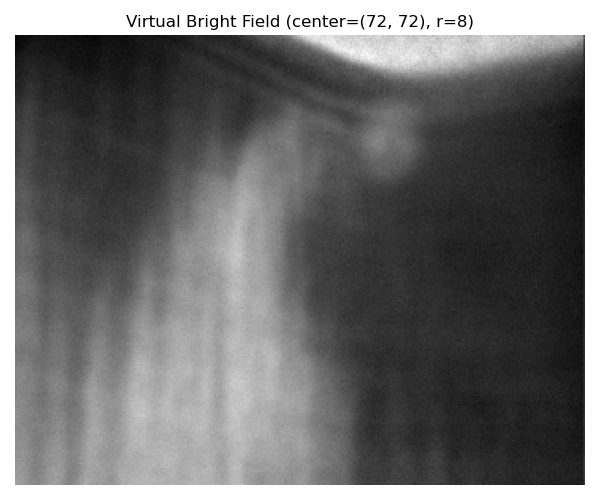

Aperture radius: 8 px, pixels in aperture: 197
virtual_bf_sum shape: (238, 360)
virtual_bf_mean shape: (238, 360)


In [14]:
# Virtual bright field (VBF) image via circular aperture at diffraction center
aperture_center = (72, 72)   # (row, col)
aperture_radius = 8          # pixels; adjust as needed

h_dp, w_dp = data.shape[2], data.shape[3]
yy_dp, xx_dp = np.indices((h_dp, w_dp))
aperture_mask = ((yy_dp - aperture_center[0])**2 + (xx_dp - aperture_center[1])**2) <= aperture_radius**2
aperture_pixels = aperture_mask.sum()

# Vectorized summation without large temporary arrays
dp_flat = data.reshape(-1, h_dp * w_dp)
vbf_sum_flat = dp_flat[:, aperture_mask.ravel()].sum(axis=1)
vbf_mean_flat = vbf_sum_flat / aperture_pixels

virtual_bf_sum = vbf_sum_flat.reshape(data.shape[0], data.shape[1])
virtual_bf_mean = vbf_mean_flat.reshape(data.shape[0], data.shape[1])
# Crop bottom region (matches density_cropped)
if pixels_to_crop > 0:
    virtual_bf_sum_full = virtual_bf_sum
    virtual_bf_mean_full = virtual_bf_mean
    virtual_bf_sum = virtual_bf_sum_full[:-pixels_to_crop, :]
    virtual_bf_mean = virtual_bf_mean_full[:-pixels_to_crop, :]
print('Virtual BF cropped shape:', virtual_bf_mean.shape)
# Plot mean-intensity virtual bright field map
fig_vbf, ax_vbf = plt.subplots(figsize=(6,5))
im_vbf = ax_vbf.imshow(virtual_bf_mean, cmap='gray', aspect='auto')
ax_vbf.set_title(f'Virtual Bright Field (center={aperture_center}, r={aperture_radius})')
ax_vbf.axis('off')
#plt.colorbar(im_vbf, ax=ax_vbf, label='Mean Intensity (a.u.)')
plt.tight_layout()
plt.savefig(f'{output_dir}\\virtual_bright_field_r{aperture_radius}.png', dpi=300)
plt.show()

print(f'Aperture radius: {aperture_radius} px, pixels in aperture: {aperture_pixels}')
print('virtual_bf_sum shape:', virtual_bf_sum.shape)
print('virtual_bf_mean shape:', virtual_bf_mean.shape)

Mean of empty slice


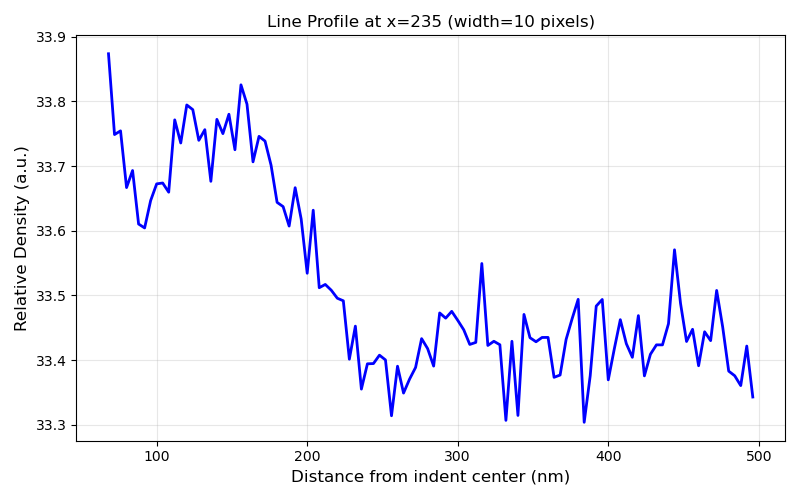

Line profile extracted from (235, 25) to (235, 150)
Profile width: 10 pixels, averaging x=[230:240]
Total distance: 496.0 nm


In [15]:
# Create line profile from (235, 25) to (235, 150) with width of 10 pixels
# This is a vertical line at x=235

x_center = 235
y_start = 25
y_end = 150
line_width = 10

# Define the region around the line
x_min = max(0, x_center - line_width // 2)
x_max = min(width, x_center + line_width // 2)

# Extract the region and average across the width
line_region = density_masked[y_start:y_end, x_min:x_max]
line_profile = np.nanmean(line_region, axis=1)

# Create distance array in nm
y_positions = np.arange(y_start, y_end)
distance_nm = (y_positions - y_start) * scan_step_nm

# Plot the line profile
fig_profile, ax_profile = plt.subplots(figsize=(8, 5))
ax_profile.plot(distance_nm, line_profile, 'b-', linewidth=2)
ax_profile.set_xlabel('Distance from indent center (nm)', fontsize=12)
ax_profile.set_ylabel('Relative Density (a.u.)', fontsize=12)
ax_profile.set_title(f'Line Profile at x={x_center} (width={line_width} pixels)', fontsize=12)
ax_profile.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}\\line_profile_vertical.png', dpi=300)
plt.show()

print(f"Line profile extracted from ({x_center}, {y_start}) to ({x_center}, {y_end})")
print(f"Profile width: {line_width} pixels, averaging x=[{x_min}:{x_max}]")
print(f"Total distance: {distance_nm[-1]:.1f} nm")

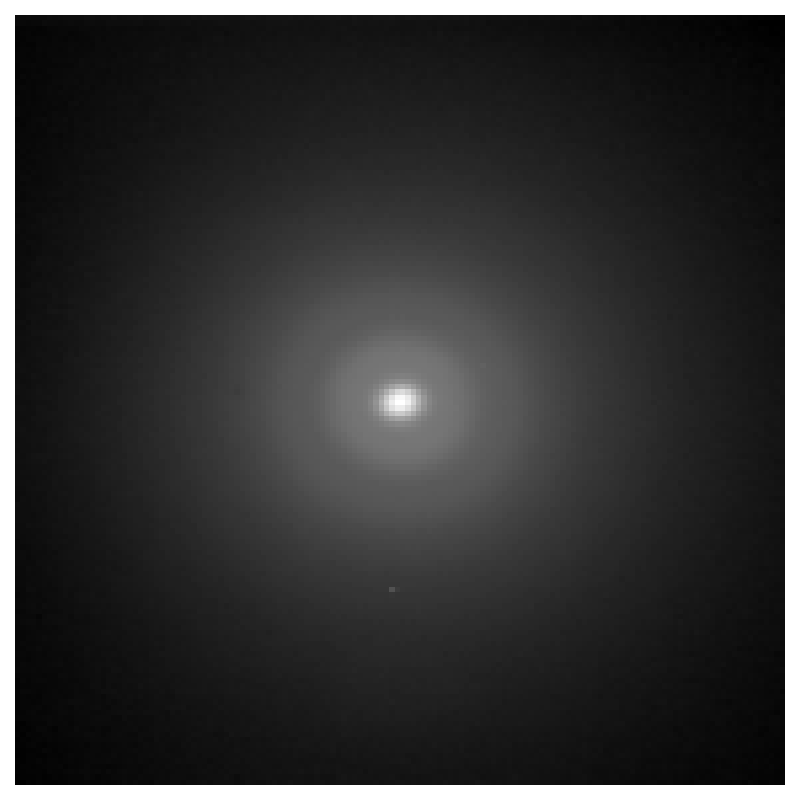

Indent mean DP stats: Min 16.57 Max 254.88 Mean 25.83 Std 10.15


In [16]:
# Extract and average diffraction patterns from indent region
square_x = 230
square_y = 50
square_size = 20
x_start = square_x
x_end = square_x + square_size
y_start = square_y
y_end = square_y + square_size
dp_stack = data[y_start:y_end, x_start:x_end, :, :]
mean_dp_indent = np.mean(dp_stack, axis=(0, 1))
fig_dp, ax_dp = plt.subplots(figsize=(8, 8))
ax_dp.imshow(mean_dp_indent, cmap='gray', norm='log')
ax_dp.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}\\mean_diffraction_pattern_indent.png', dpi=300)
plt.show()
print('Indent mean DP stats:',
      f'Min {mean_dp_indent.min():.2f}',
      f'Max {mean_dp_indent.max():.2f}',
      f'Mean {mean_dp_indent.mean():.2f}',
      f'Std {mean_dp_indent.std():.2f}')

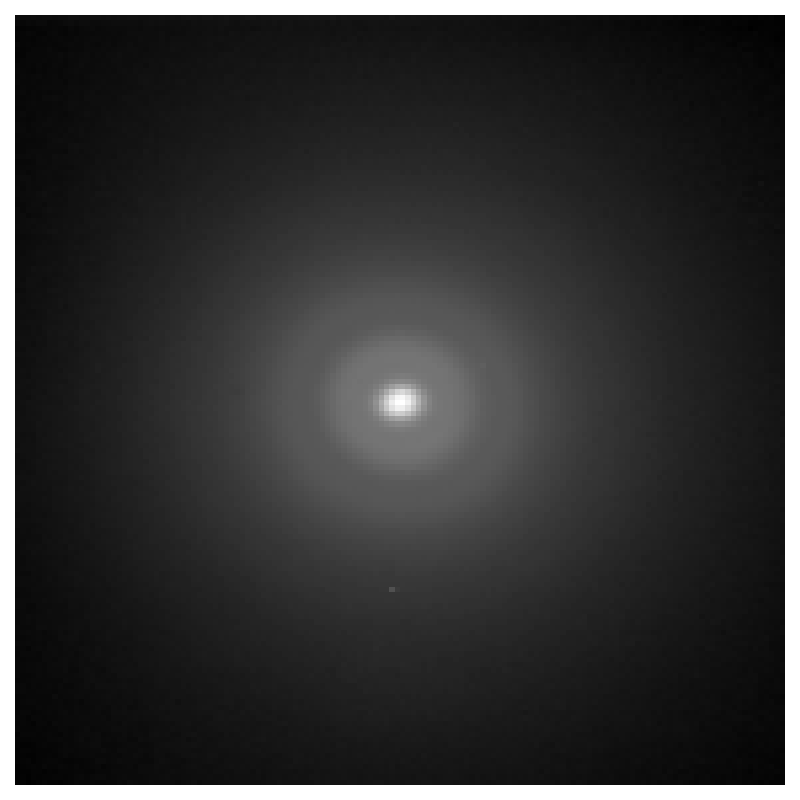

Away mean DP stats: Min 15.37 Max 255.00 Mean 24.24 Std 9.76


In [17]:
# Extract and average diffraction patterns away from indent
square_x = 230
square_y = 160
square_size = 20
x_start = square_x
x_end = square_x + square_size
y_start = square_y
y_end = square_y + square_size
dp_stack = data[y_start:y_end, x_start:x_end, :, :]
mean_dp_away = np.mean(dp_stack, axis=(0, 1))
fig_dp, ax_dp = plt.subplots(figsize=(8, 8))
ax_dp.imshow(mean_dp_away, cmap='gray', norm='log')
ax_dp.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}\\mean_diffraction_pattern_awayfromindentarea.png', dpi=300)
plt.show()
print('Away mean DP stats:',
      f'Min {mean_dp_away.min():.2f}',
      f'Max {mean_dp_away.max():.2f}',
      f'Mean {mean_dp_away.mean():.2f}',
      f'Std {mean_dp_away.std():.2f}')

In [18]:
# Radial profile (undeformed / away region) out to 50 pixels
dp = mean_dp_away
h, w = dp.shape
cy, cx = h/2.0, w/2.0
yy, xx = np.indices(dp.shape)
r = np.sqrt((yy - cy)**2 + (xx - cx)**2).astype(int)
max_r = 50
mask = r <= max_r
counts = np.bincount(r[mask].ravel(), minlength=max_r+1)
sums = np.bincount(r[mask].ravel(), weights=dp[mask].ravel(), minlength=max_r+1)
radial_profile_away = sums / np.maximum(counts, 1)
radii = np.arange(len(radial_profile_away))
np.save(f'{output_dir}\\radial_profile_awayfromindentarea.npy', radial_profile_away)
print('Away radial profile done.')

Away radial profile done.


In [19]:
# Radial profile (deformed / indent region) out to 50 pixels
dp = mean_dp_indent
h, w = dp.shape
cy, cx = h/2.0, w/2.0
yy, xx = np.indices(dp.shape)
r = np.sqrt((yy - cy)**2 + (xx - cx)**2).astype(int)
max_r = 50
mask = r <= max_r
counts = np.bincount(r[mask].ravel(), minlength=max_r+1)
sums = np.bincount(r[mask].ravel(), weights=dp[mask].ravel(), minlength=max_r+1)
radial_profile_indent = sums / np.maximum(counts, 1)
radii_indent = np.arange(len(radial_profile_indent))
np.save(f'{output_dir}\\radial_profile_indentarea.npy', radial_profile_indent)
print('Indent radial profile done.')

Indent radial profile done.


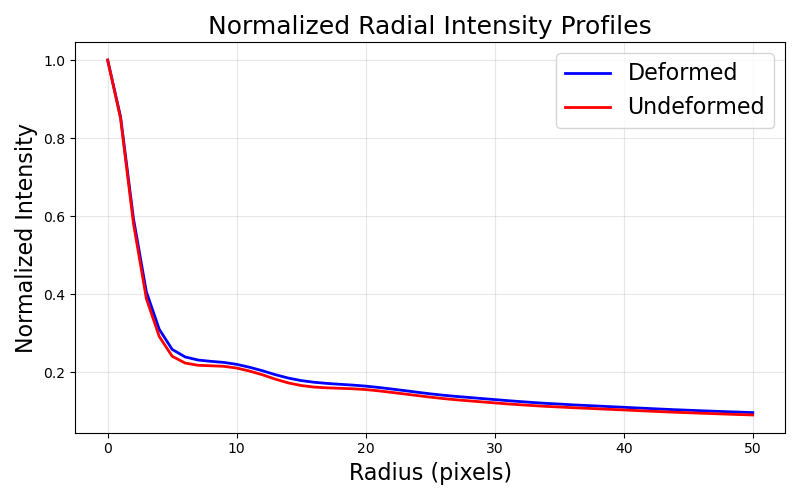

In [23]:
# Overlay normalized radial intensity profiles (Deformed vs Undeformed)
if len(radial_profile_indent) != len(radial_profile_away):
    max_len = min(len(radial_profile_indent), len(radial_profile_away))
    rp_indent = radial_profile_indent[:max_len]
    rp_away = radial_profile_away[:max_len]
    radii_plot = np.arange(max_len)
else:
    rp_indent = radial_profile_indent
    rp_away = radial_profile_away
    radii_plot = np.arange(len(rp_indent))

# Normalize
rp_indent_n = rp_indent / rp_indent.max()
rp_away_n = rp_away / rp_away.max()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(radii_plot, rp_indent_n, '-', color='blue', linewidth=2, label='Deformed')
ax.plot(radii_plot, rp_away_n, '-', color='red', linewidth=2, label='Undeformed')
ax.set_xlabel('Radius (pixels)', size=16)
ax.set_ylabel('Normalized Intensity', size=16)
ax.set_title('Normalized Radial Intensity Profiles', size=18)
ax.legend(fontsize=16)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}\\radial_profile_overlay02.png', dpi=300)
plt.show()